In [1]:
# These are some basic packages
import random, re, math, os, functools, itertools,collections

# ML packages
import numpy as np
import pandas as pd
import tensorflow as tf
# These are performance metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
# This for class weights
from  sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from kaggle_datasets import KaggleDatasets

2022-07-26 22:51:41.225292: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-26 22:51:41.225425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Detect the hardware and tell the appropriate distribution strategy

In [2]:
# Make the system tune the number of threads for us
AUTO = tf.data.experimental.AUTOTUNE

INTER_THREADS_NB = None
INTRA_THREADS_NB = None

# TF2.X runs eagerly by default
FORCE_MODE  = False
RUN_EAGERLY = False

# Logical GPU memory limit 
LGPU_MEMORY_LIMIT = 7*1024
logical_gpu_name = lambda i: f"/device:GPU:{i}"

# Add more mixed precision and/or XLA to allow the TPU memory to handle larger batch sizes 
# and can speed up the training process
MIXED_PRECISION = False
XLA_ACCELERATE = False

PREFETCH_SIZE = AUTO
SHUFFLE_SIZE  = 2048

# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU: ', tpu.master())
except ValueError:
    tpu = None

STRATEGY = None    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    STRATEGY = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = 16 * STRATEGY.num_replicas_in_sync
else:
    try:
        gpus = tf.config.list_physical_devices('GPU')
    except ValueError:
        gpus = None
    if gpus:
        BATCH_SIZE = 8
        SHUFFLE_SIZE  = None
        PREFETCH_SIZE = 16
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            #create logical GPUs    
            tf.config.set_logical_device_configuration(
                    gpus[0],
                    [
                       tf.config.LogicalDeviceConfiguration(memory_limit=LGPU_MEMORY_LIMIT),
                       tf.config.LogicalDeviceConfiguration(memory_limit=LGPU_MEMORY_LIMIT)
                    ]
                )
            
            #define stategy
            lgpus = tf.config.list_logical_devices('GPU')
            STRATEGY = tf.distribute.MirroredStrategy(devices=list( map(
                                                                        logical_gpu_name,
                                                                        range(len(lgpus))
                                                                       )
                                                                  )
                                                     )
            
            print( f"Physical GPUs: {gpus} - Logical GPUs : {lgpus}")
        
        except RuntimeError as e:
            print(e)
            
    else:
        STRATEGY = tf.distribute.get_strategy()
        BATCH_SIZE = 32
        
    # run tf functions eagerly
    if FORCE_MODE:
        tf.config.run_functions_eagerly(RUN_EAGERLY)
        print(f"Eager mode forced to {RUN_EAGERLY}")

    #interop threads (to run different graph)
    if INTER_THREADS_NB is not None:
        tf.config.threading.set_inter_op_parallelism_threads(INTER_THREADS_NB)
        print(f"Inter-op threads set to {INTER_THREADS_NB}")

    #intraop threads (to run within a graph)
    if INTRA_THREADS_NB is not None:
        tf.config.threading.set_intra_op_parallelism_threads(INTRA_THREADS_NB)
        print(f"Intra-op threads set to {INTRA_THREADS_NB}")
        
print("REPLICAS: ", STRATEGY.num_replicas_in_sync)

# mixed precision
if MIXED_PRECISION :
    if tpu: precision = 'mixed_bfloat16'
    else: precision = 'mixed_float16'
    policy = tf.keras.mixed_precision.experimental.Policy(precision)
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print(f'Mixed precision enabled: {precision}')

# xla accelerate    
if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')
    
# Configuration for image size, training epoch, batch size, and random seed
IMAGE_SIZE = [512, 512]
EPOCHS = 100
SEED = 100
tf.random.set_seed(SEED)

Running on TPU:  grpc://10.0.0.2:8470


2022-07-26 22:51:47.987627: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 22:51:47.990866: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-26 22:51:47.990906: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 22:51:47.990935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c27ec1a84694): /proc/driver/nvidia/version does not exist
2022-07-26 22:51:47.994053: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


### Set the data access

In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
# These are available image sizes in the data set
GCS_PATH_SELECT = { 
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
TRAINING_FILENAMES   = lambda img_size=IMAGE_SIZE[0]: tf.io.gfile.glob(GCS_PATH_SELECT[img_size] + '/train/*.tfrec')
VALIDATION_FILENAMES = lambda img_size=IMAGE_SIZE[0]: tf.io.gfile.glob(GCS_PATH_SELECT[img_size] + '/val/*.tfrec')
TEST_FILENAMES       = lambda img_size=IMAGE_SIZE[0]: tf.io.gfile.glob(GCS_PATH_SELECT[img_size] + '/test/*.tfrec')

### Set  functions to 
- decode image
- read labeled tfrec files (i.e. training & validation set) 
- unlabeled tfrec files (i.e. test set) 
- load image data

In [4]:
def decode_image(image_data,img_size):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.reshape(image, [img_size,img_size, 3])
    return image

def read_labeled_tfrecord(example,img_size):
    
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'],img_size)
    label = tf.cast(example['class'], tf.int32)
    
    return image, label

# This is for data visualization
def read_labeled_id_tfrecord(example,img_size):
    
    LABELED_ID_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([],tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_ID_TFREC_FORMAT)
    image = decode_image(example['image'],img_size)
    label = tf.cast(example['class'], tf.int32)
    idnum =  example['id']
    
    return image, label, idnum

def read_unlabeled_tfrecord(example,img_size):
    
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'],img_size)
    idnum = example['id']
    
    return image, idnum

# For best performance, read from multiple tfrec files at once
# Disregard data's order, since data will be shuffled
def load_dataset(filenames,img_size, labeled = True, with_id = False,ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # Disable order to increase running speed
    # Automatically interleaves reading
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    # Use data in the shuffled order
    dataset = dataset.with_options(ignore_order)
    
    # Returns a dataset of (image, label) pairs if labeled = True (i.e. training & validation set)
    # or (image, id) pair if labeld = False (i.e. test set)
    if labeled == True:
        tfrecord_reader = functools.partial(read_labeled_tfrecord,img_size=img_size)
        if with_id == True:
            tfrecord_reader = functools.partial(read_labeled_id_tfrecord,img_size=img_size)
    else:
        tfrecord_reader = functools.partial(read_unlabeled_tfrecord,img_size=img_size)
    
    dataset = dataset.map(tfrecord_reader, num_parallel_calls=AUTO)
    
    return dataset

# possible kwargs: labeled,ordered,with_id
def get_training_dataset(img_size=IMAGE_SIZE[0],**kwargs):
    train = load_dataset(TRAINING_FILENAMES(img_size),img_size, **{**kwargs,'labeled':True} )
    return train

def get_validation_dataset(img_size=IMAGE_SIZE[0],**kwargs):
    validation = load_dataset(VALIDATION_FILENAMES(img_size),img_size, **{**kwargs,'labeled':True } )
    return validation

def get_test_dataset(img_size=IMAGE_SIZE[0],**kwargs):
    test = load_dataset(TEST_FILENAMES(img_size) ,img_size, **{**kwargs,'labeled':False })
    return test

In [5]:
UT_MODEL      = tf.keras.applications.EfficientNetB4
UT_PREPROCESS = lambda x,y,id: tf.image.resize_with_pad(x,380,380)
UT_DECODER    =  tf.keras.applications.efficientnet.decode_predictions
UT_NAME       = 'efficientnetb4'
PRED_DS       = get_training_dataset(img_size=331,with_id=True,ordered = True)

densenet201 = """
UT_MODEL      = tf.keras.applications.DenseNet201
UT_PREPROCESS = lambda x,y,id: tf.keras.applications.densenet.preprocess_input(tf.cast(x, tf.float32))
UT_DECODER    =  tf.keras.applications.densenet.decode_predictions
UT_NAME       = 'densenet201'
PRED_DS       = get_training_dataset(img_size=224,with_id=True,ordered = True)
"""

2022-07-26 22:51:55.245972: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


### Count the number of images

In [6]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES())  # Number of images in training set
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES())  # Number of images in validation set
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES())  # Number of images in test set
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE  # Steps of each epoch
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

2022-07-26 22:51:55.740942: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-26 22:51:55.810652: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-26 22:51:55.894859: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


### Show all the classes we have

In [7]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 


## Step 2: Set some visualization functions

### Set training and validation curve function to show the changes in loss and accuracy

In [8]:
def plot_train_valid_curves(training, validation, title, subplot):
    
    if subplot % 10 == 1:
        plt.subplots(figsize = (15,15), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation.'])

### Set a function to plot confusion matrix

In [9]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize = (20,20))  # Specify the size of confusion matrix
    ax = plt.gca()
    ax.matshow(cmat, cmap = 'Reds')  # Draw a matrix
    ax.set_xticks(range(len(CLASSES)))  # Set the range of X coordinate according to #classes
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})  # Set the font size of X coordinate
    # Rotate labels on X coordinate to make them look better
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "left", rotation_mode = "anchor")
    ax.set_yticks(range(len(CLASSES)))  # Set the range of Y coordinate according to #classes
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})  # Set the font size of Y coordinate
    # Rotate labels on Y coordinate to make them look better
    plt.setp(ax.get_yticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    # Round F1 score, precision, and recall to the nearest fourth decimal place
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.4f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.4f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.4f} '.format(recall)
    # Add some comments about F1 score, precision, and recall on the plot
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict = {'fontsize': 18, 'horizontalalignment': 'right', 'verticalalignment': 'top', 'color': 'Blue'})
    plt.show()

### Show the beautiful flowers (refer to Dimitre Oliveira)

In [10]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (for test data)
    return numpy_images, numpy_labels


def title_from_label_and_target_(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


def display_one_flower(image, title, subplot, red = False, titlesize = 16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize = int(titlesize) if not red else int(titlesize / 1.2), color = 'red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2] + 1)


def display_batch_of_images(databatch, predictions = None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows
    #print(f"rows: {rows} cols: {cols}")
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows,cols,1)
    if rows < cols:
        plt.figure(figsize = (FIGSIZE, FIGSIZE / cols*rows))
    else:
        plt.figure(figsize = (FIGSIZE / rows * cols,FIGSIZE))
    
    # Display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target_(predictions[i], label)
        dynamic_titlesize = FIGSIZE * SPACING / max(rows,cols) * 40 + 3
        subplot = display_one_flower(image, title, subplot, not correct, titlesize = dynamic_titlesize)
    
    # Layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace = 0, hspace = 0)
    else:
        plt.subplots_adjust(wspace = SPACING, hspace = SPACING)
    plt.show()

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis = -1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', should be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red = False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize = 14, color = 'red' if red else 'black')
    return subplot + 1

#def display_n_images_with_predictions(images, predictions, labels,n=10):
#    subplot = 331
#    plt.figure(figsize = (13,13))
#    for i, image in enumerate(images):
#        title, correct = title_from_label_and_target(predictions[i], labels[i])
#        subplot = display_one_flower_eval(image, title, subplot, not correct)
#        if i >= (n-1):
#            break;
#    plt.tight_layout()
#    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
#    plt.show()

### Data augmentation

In [11]:
ds_map_func = lambda func: lambda ds: ds.map(func,num_parallel_calls=AUTO) 

data_augment_layers = tf.keras.Sequential(
            layers = [
                #tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2,fill_mode='nearest', dtype="float32"),
                tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2,width_factor=0.2,fill_mode='nearest',dtype="float32"),
                #tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2,width_factor=0.2,fill_mode='nearest',dtype="float32"),
                tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2,dtype="float32"),
                tf.keras.layers.experimental.preprocessing.RandomFlip(dtype="float32")
            ]
)

def apply_data_augment(ds):
    
    def f(x,y):
        #choice = tf.random.uniform(shape=[],minval=0,maxval=len(data_augment_models),dtype=tf.int32).numpy()
        #data_augment_model = data_augment_models[choice]
        #print(type(data_augment_model))
        #if tf.random.uniform([]) < 0.5:
        return ( data_augment_layers(x), y )
        #else:
        #    return (x,y)
        

    return ds_map_func(f)(ds)


### Gain training/validation/test datasets

In [12]:
#all_ids = lambda ds: next(iter(ds.map(lambda image, label,id: id).batch(NUM_TRAINING_IMAGES))).numpy()

add_remove_batch_dim = lambda x : tf.squeeze( data_augment_layers( tf.expand_dims(x, axis=0) ), axis=0)
is_iterable          = lambda x: isinstance(x,collections.abc.Iterable)

batch_spec         = lambda ds: tf.data.experimental.get_structure(ds)
is_batched_ds      = lambda ds: (batch_spec(ds))[0].shape[0] == None
len_batch_elem     = lambda ds,i: len((batch_spec(ds))[i].shape)
nb_batch_elem      = lambda ds: len((batch_spec(ds)))
is_batched_tensor  = lambda t: t.shape[0] == None

remove_id = lambda ds: ds.map(lambda image, label, idnum: [image, label])

#def all_labels(ds):
#    acc = []
#    def add_acc(x):
#        if is_iterable(x):
#            acc.extend(x)
#        else:
#            acc.append(x)
#    if nb_batch_elem(ds) == 3:
#        for _,labels,_ in ds:
#            add_acc(labels.numpy())
#    elif nb_batch_elem(ds) == 2:
#        for _,labels in ds:
#            add_acc(labels.numpy())
#    return acc

all_labels = lambda ds: next(iter(ds.map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy() 


"""
def prepare_train(train,data_aug=False,force=False,shuffle_size=2048,bsize=BATCH_SIZE):
    if data_aug:
        train = apply_data_augment(train,force=force)
    train = train.shuffle(shuffle_size)
    train = train.batch(bsize)
    train = train.prefetch(AUTO)
    return train
"""

def shuffle_batch_prefetch(ds,shuffle_size=SHUFFLE_SIZE,batch_size=BATCH_SIZE,prefetch_size=PREFETCH_SIZE):
    if shuffle_size is not None:
        ds = ds.shuffle(shuffle_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(prefetch_size)
    return ds

def batch_prefetch(ds,batch_size=BATCH_SIZE,prefetch_size=PREFETCH_SIZE):
    ds = ds.batch(batch_size)
    ds = ds.prefetch(prefetch_size)
    return ds

#def expand_ds(ds,num,size):
#    tmp = ds.concatenate(apply_data_augment(ds.repeat(num).batch(BATCH_SIZE)))
#    return tmp.interleave(lambda x,y:  tf.data.Dataset.from_tensors((x,y)),
#                          cycle_length=int(size*(num+1)), 
#                          block_length=1)

#
get_samples   = lambda ds,n=20,p=1: ds.take(count=n).batch(int(n/p))
get_one_iter = lambda ds: next(iter(ds))

In [13]:
train_ds = get_training_dataset(with_id=True)
val_ds   = get_validation_dataset()
test_ds  = get_test_dataset(ordered=True)
train_sample = remove_id(get_samples(train_ds))
val_sample   = get_samples(val_ds)
test_sample  = get_samples(test_ds)

2022-07-26 22:51:57.573643: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-26 22:51:57.670219: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-07-26 22:51:57.845270: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [14]:
"""
    Extract prefix (3 first letters) of wordnet classes from list of predictions <preds>
    <preds> is an iterable of (wordnet class,proba)
    Returns list of prefix
"""
get_wordnet_class_prefixs = lambda preds : list(map(lambda t: t[0][0:3], preds))

def get_index(wordnet_classes,s):
    try:
        return (wordnet_classes.index(s) + 1)
    except:
        return -1
    
get_first = lambda word_net_classes: word_net_classes[0]

def get_wnc_prefix(preds,labels,ids,wnc_prefix='n11'):
    """
        Map predictions to a dataframe.
        <preds> is an iterable of (wordnet class,proba)
        labels is an iterable of label
        ids labels is an iterable of id
        Returns a dataframe with the following columns:
        - wnc_prefix: position of wnc_prefix (-1 if not in the top predictions)
        - first: wnc_prefix of the first prediction
        - label: associated label
        - id: associated id
    """
    wordnet_class_prefixs =list(map(get_wordnet_class_prefixs, preds))
    wncs    = list(map(functools.partial(get_index,s=wnc_prefix),wordnet_class_prefixs))
    firsts  = list(map(get_first,wordnet_class_prefixs))
    return pd.DataFrame(data={wnc_prefix:wncs,'first':firsts,'label':labels,'id':ids})

#def mk_predicter(model,preprocess):
#    """
#        Make predicter as a tf.function (executable under a graph) with <model> and <preprocess>
#    """
#    @tf.function
#    def predicter(x):
#        return model(preprocess(x))
#    return predicter

"""
    Make decoder with <decoder> for <top> first predictions  
"""
mk_decoder = lambda decoder,top: functools.partial(decoder,top=top)

# not worrking under tpu
#def predict_wnc(dist_dataset,predicter,decoder,strategy=STRATEGY):
#   """
#        Predict wordnet class with <predicter> and <decoder> for data contained in <dist_dataset>
#        <predicter> is executed under <strategy>
#        Return list of numpy arrays: [predictions,labels,ids]
#    """
#    acc = [[],[],[]]
#    for xs,ys,ids in dist_dataset:
#        preds = strategy.run(predicter,args=(xs,))
#        _ = list(map(lambda t: t[0].extend(t[1]), zip(acc,[decoder(preds.numpy()),ys.numpy(),ids.numpy()]) ))
#    return acc

def predict_wnc(ds,preprocess,predicter,decoder,strategy=STRATEGY,size=NUM_TRAINING_IMAGES):
    with strategy.scope():
        model = tf.keras.Sequential([predicter()])
    preds = model.predict(batch_prefetch(ds.map(preprocess)))
    ys = next(iter(ds.map(lambda _,y, id: y ).batch(size))).numpy()
    ids = next(iter(ds.map(lambda _,y, id: id ).batch(size))).numpy()
    return [decoder(preds),ys,ids]
    
def count_wnc_prefix(df_wnc,wnc_prefix='n11'):
    """
      Create a dataframe with the following columns
      - wnc_prefix: count of wnc_prefix (for label)
      - total : total count (for label)
      with label as index
    """
    groups   = df_wnc.groupby(by=['label',wnc_prefix],as_index=False).count()
    groups.rename(columns={'first':'subcount'},inplace=True)
    # total per label
    totals = groups.groupby(by=['label'],as_index=False)['subcount'].sum()
    totals.rename(columns={'subcount':'total'},inplace=True)
    # create total column in groups
    for l in totals['label'].values:
        groups.loc[groups['label'] == l,['total']] = totals[totals['label'] == l ]['total'].iloc[0]
    # labels wo wnc_prefix in the top
    df1 = groups.loc[(groups["subcount"] == groups["total"]) & (groups[wnc_prefix] == -1),["label","subcount"]]
    df1["subcount"] = 0
    # labels with wnc_prefix in the top
    df2 = (groups[groups[wnc_prefix] != -1].groupby(by=["label"],as_index=False).sum())[["label","subcount"]]
    # create final dataframe
    df = pd.concat([df1,df2])
    df.rename(columns={"subcount":wnc_prefix},inplace=True)
    # create total column in final dataframe
    for l in totals['label'].values:
        df.loc[df['label'] == l,['total']] = totals[totals['label'] == l ]['total'].iloc[0]
    #set label as index
    #df.set_index('label',inplace=True)
    return df

def display_wnc_prefix_counts(wnc_prefix_counts,wnc_prefix='n11'):
    """
    """
    fig,ax = plt.subplots(figsize=(20,10))
    total = wnc_prefix_counts[wnc_prefix].sum()
    empty = len(wnc_prefix_counts[wnc_prefix_counts[wnc_prefix] == 0])
    title = f'Nb of pictures per label [total: {total} ({wnc_prefix}) - empty classes: {empty}]'
    _ = wnc_prefix_counts.plot(kind='bar',ax=ax,title=title)

def get_hash_table(wnc_prefix_df,wnc_prefix='n11'):
    """
        Create a hash table based on a dataframe of wnc prefixs (obtained by get_wnc_prefix)
    """
    return tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(wnc_prefix_df['id'].values, wnc_prefix_df[wnc_prefix].values),
        default_value=-1
    )

def make_filter(wnc_prefix_df,wnc_prefix='n11'):
    """
        Create a filter based on <wnc_prefix_df>. Uses a hash table.
    """
    table = get_hash_table(wnc_prefix_df,wnc_prefix='n11')
    def f(id):
        return tf.math.not_equal(table.lookup(id), tf.constant(-1,dtype=tf.int64), name="filter")
    return f


In [15]:
def select_img(wnc_prefixes,selective,num_classes= len(CLASSES),wnc_prefix='n11'):
    wnc_prefixes['selected'] = -1
    selected = wnc_prefixes.columns.get_loc("selected")
    selected_labels = set()
    all_classes = set(range(num_classes))
    i = 1
    while(len(all_classes.difference(selected_labels)) > 0):
        if selective == True:
            indexes = wnc_prefixes[ ~(wnc_prefixes['label'].isin(selected_labels)) & (wnc_prefixes[wnc_prefix] <= i) & (wnc_prefixes[wnc_prefix] != -1) ].index
        else:
            indexes = wnc_prefixes[(wnc_prefixes[wnc_prefix] <= i) & (wnc_prefixes[wnc_prefix] != -1) ].index
        wnc_prefixes.iloc[indexes,selected] = 1
        wnc_prefix_counts = count_wnc_prefix(wnc_prefixes[wnc_prefixes['selected'] == 1])
        selected_labels   = set(wnc_prefix_counts[wnc_prefix_counts[wnc_prefix] != 0]['label'].values)
        #print(len(set(range(104)).difference(selected_labels)))
        nb_selected = len(wnc_prefixes[wnc_prefixes['selected'] == 1])
        #print(f"selected: {nb_selected}" )
        i = i + 1
    wnc_prefixes.iloc[wnc_prefixes[wnc_prefixes['selected'] == -1].index,wnc_prefixes.columns.get_loc(wnc_prefix)] = -1
    return nb_selected

def get_filtered_ds(ds,preprocess,predicter,decoder,top=5,selective=True,strategy=STRATEGY,size=NUM_TRAINING_IMAGES,pred_ds=PRED_DS):
    # create distributed dataset based on initial dataset
    #dist_dataset = strategy.experimental_distribute_dataset(ds)
    #create predicter and decoder
    #tf_predicter = mk_predicter(predicter,preprocess)  
    top_decoder  = mk_decoder(decoder,top)
    #do predictions
    pred_ds = ds if pred_ds is None else pred_ds
    preds = predict_wnc(pred_ds,preprocess,predicter,top_decoder,strategy,size=size)
    # list prefixes along with id, to be used to create a filter
    wnc_prefixes = get_wnc_prefix(*preds)
    nb_selected = select_img(wnc_prefixes,selective=selective)
    #filter orginal dataset
    f = make_filter(wnc_prefixes)
    filtered_ds = ds.filter(lambda x,y,id: f(id))
    return (remove_id(filtered_ds),wnc_prefixes,nb_selected)

In [16]:
predicter    = UT_MODEL
preprocess   = UT_PREPROCESS
decoder      = UT_DECODER
ds = get_training_dataset(with_id=True,ordered=True)

2022-07-26 22:51:58.384388: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [17]:
(filtered_ds,wnc_prefixes,nb_selected) = get_filtered_ds(ds,preprocess,predicter,decoder,top=10,strategy=STRATEGY,size=NUM_TRAINING_IMAGES)

78872576/78864416 [==============================] - 1s 0us/step


2022-07-26 22:53:16.793506: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 36763, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658875996.790165178","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 36763, Output num: 0","grpc_status":3}


40960/35363 [==================================] - 0s 0us/step


In [18]:
#(filtered_ds1,wnc_prefixes1,nb_selected1) = get_filtered_ds(ds,preprocess,predicter,decoder,selective=False,top=10,strategy=STRATEGY,size=NUM_TRAINING_IMAGES)

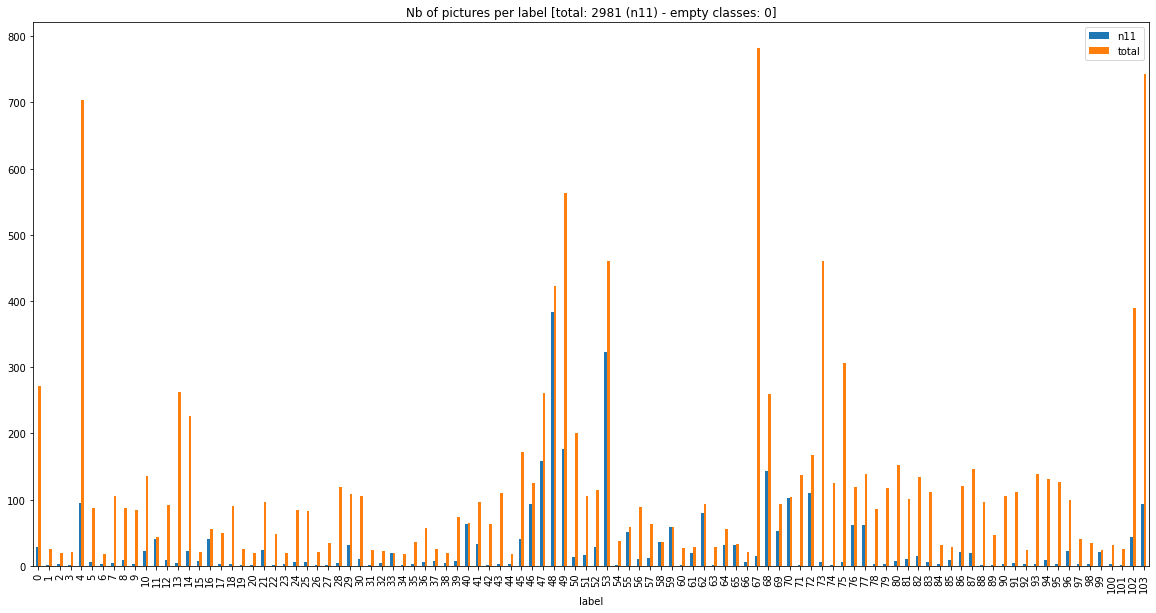

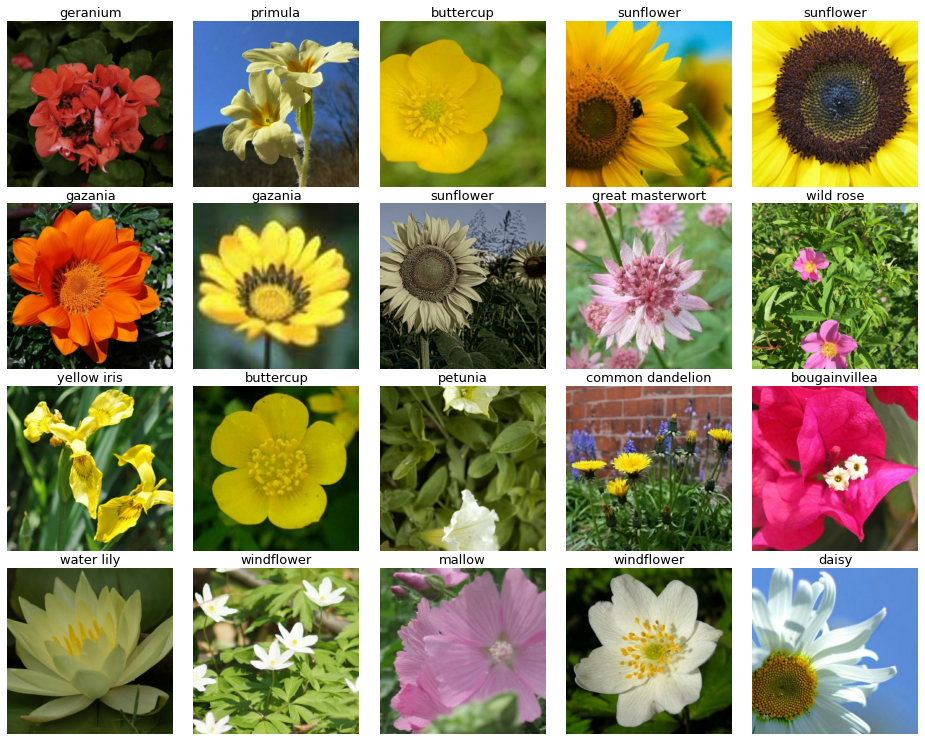

In [19]:
wnc_prefix_counts = count_wnc_prefix(wnc_prefixes)
wnc_prefix_counts.set_index(keys='label',inplace=True)
display_wnc_prefix_counts(wnc_prefix_counts)
display_batch_of_images(get_one_iter(get_samples(filtered_ds)))

In [20]:
#wnc_prefix_counts1 = count_wnc_prefix(wnc_prefixes1)
#wnc_prefix_counts1.set_index(keys='label',inplace=True)
#display_wnc_prefix_counts(wnc_prefix_counts1)
#display_batch_of_images(get_one_iter(get_samples(filtered_ds1)))

### Show the beautiful flowers in training set before with data augmentation

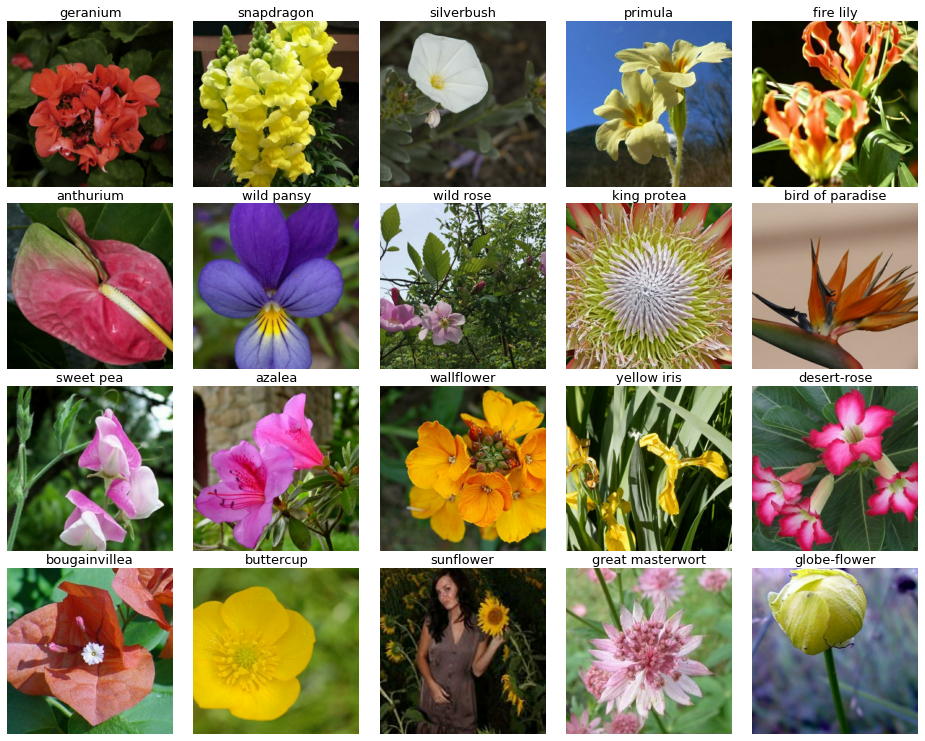

In [21]:
display_batch_of_images(get_one_iter(train_sample))

### Show the beautiful flowers in validation set (wo data augmentation)

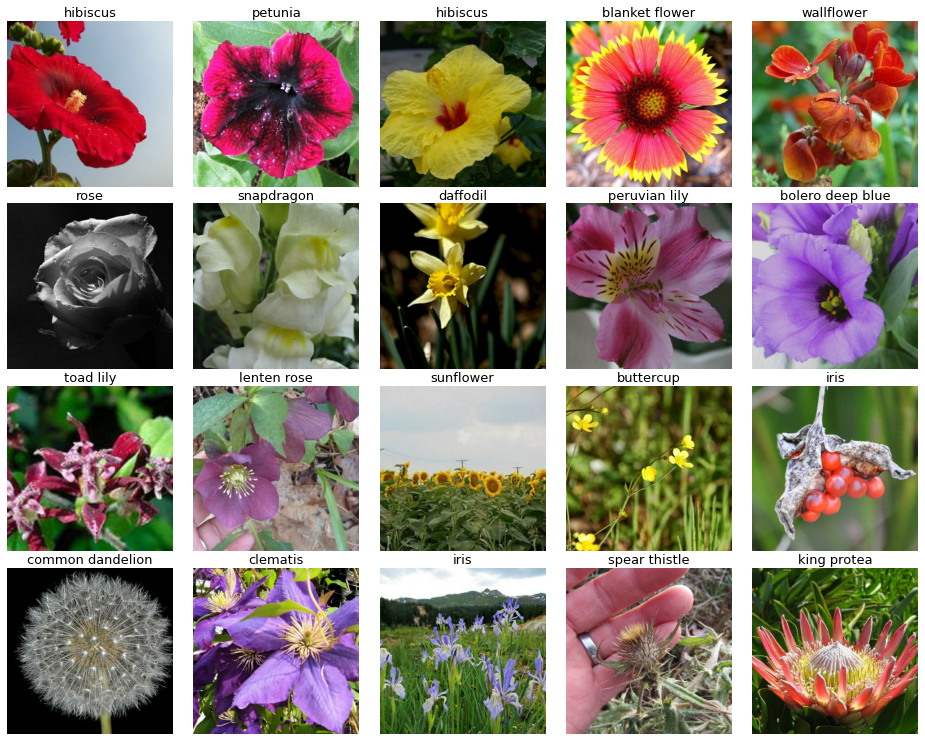

In [22]:
display_batch_of_images(get_one_iter(val_sample))

### Show the beautiful flowers in test set (wo data augmentation)

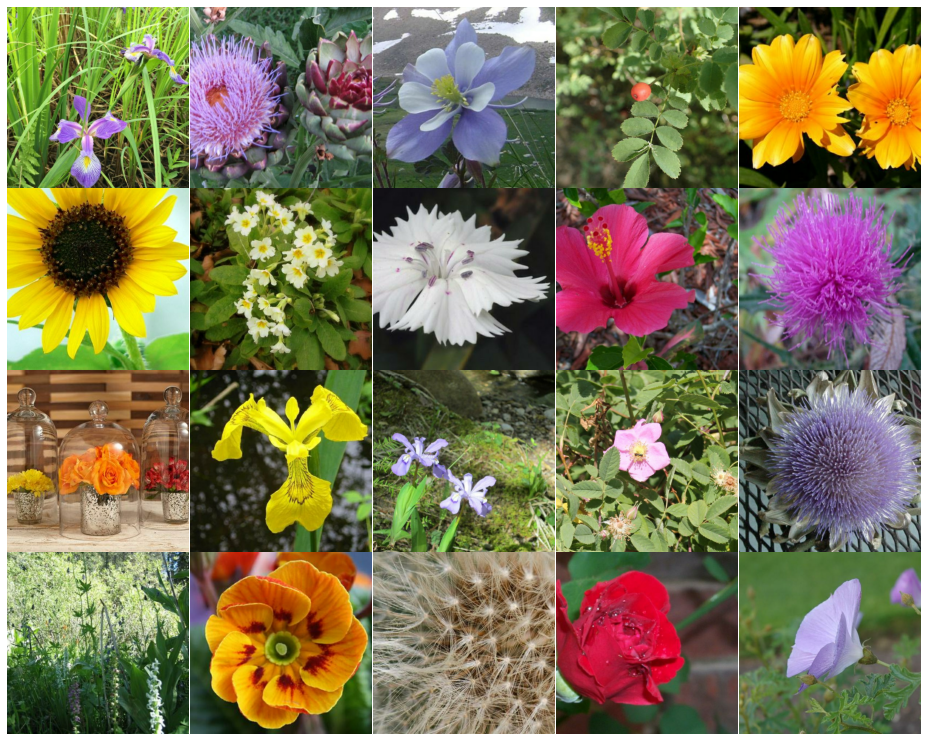

In [23]:
display_batch_of_images(get_one_iter(test_sample))

### Show example augmentation

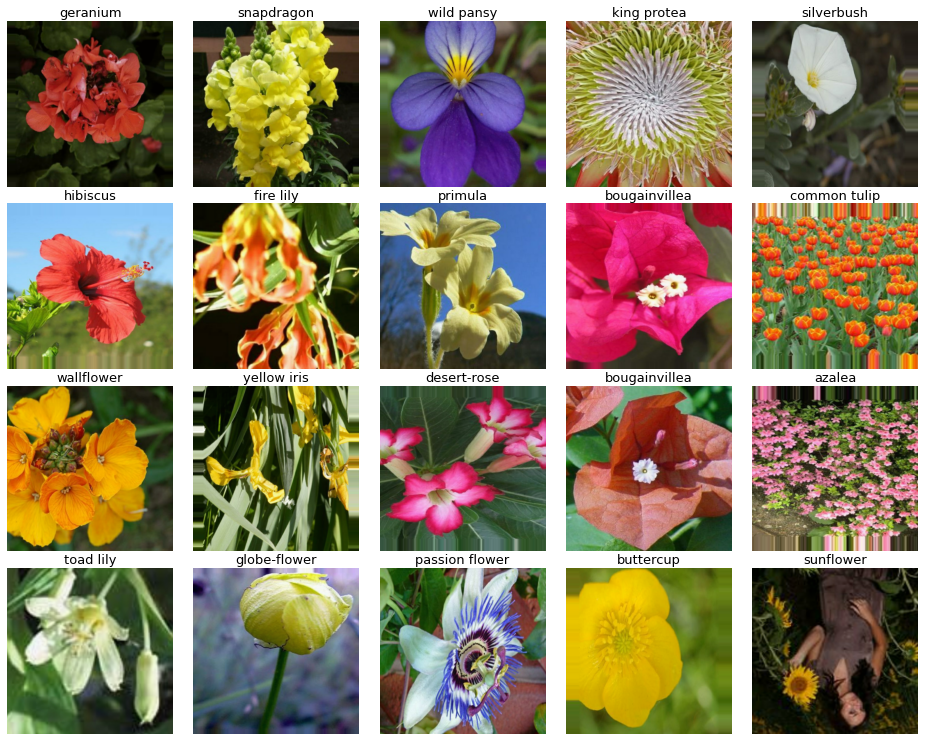

In [24]:
display_batch_of_images(get_one_iter(apply_data_augment(train_sample))) 

## Step 4: Build the model and make prediction

### Customize learning rate scheduler and visualize it

In [25]:
# Visualization changes in learning rate
def plot_lrnfn(lrfn,epochs=EPOCHS):
    rng = [i for i in range(25 if epochs<25 else epochs)]
    y = [lrfn(x) for x in rng]
    plt.figure(figsize=(20,10))
    plt.plot(rng, y)
    plt.xticks(rng)
    plt.grid()
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# ramp-up then constant then exponential decay learning rate    
def mk_lrfn(strategy=STRATEGY,epoch=EPOCHS,LR_START = 0.00001,LR_MAX = 0.00005,LR_MIN = 0.00001,LR_RAMPUP_EPOCHS = 5,LR_SUSTAIN_EPOCHS = 0,LR_EXP_DECAY = .8):
    
    LR_MAX_ = LR_MAX * strategy.num_replicas_in_sync
    
    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX_ - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX_
        else:
            lr = (LR_MAX_ - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
        return lr
    
    return lrfn

# constant lr
mk_const_lrfn = lambda c : lambda _: c
#make learning rate callback
mk_lr_callback = lambda lrfn: tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True) 

#make early stopping callback
mk_early_stopping_cb = lambda fit_patience=5,fit_min_delta=0.002,metric="sparse_categorical_accuracy": tf.keras.callbacks.EarlyStopping(monitor=f'val_{metric}',
                                                                                                   mode='max',
                                                                                                   patience=fit_patience,
                                                                                                   min_delta=fit_min_delta,
                                                                                                   restore_best_weights=True,
                                                                                                   verbose=1)

Learning rate schedule: 1e-05 to 0.0004 to 1e-05
Learning rate schedule: 1e-05 to 0.0004 to 1.43e-05


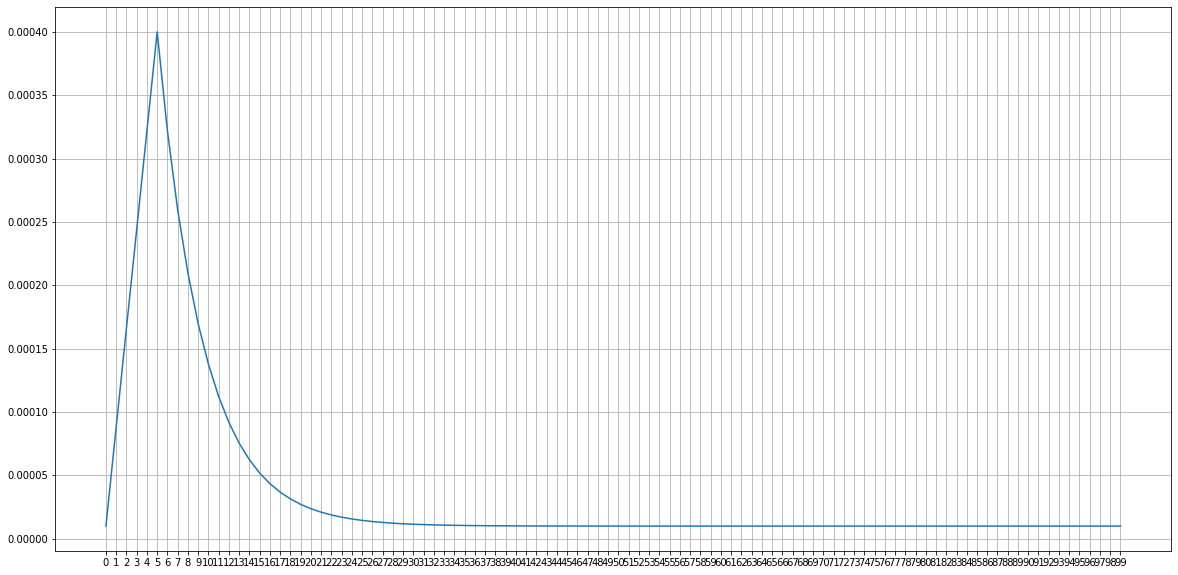

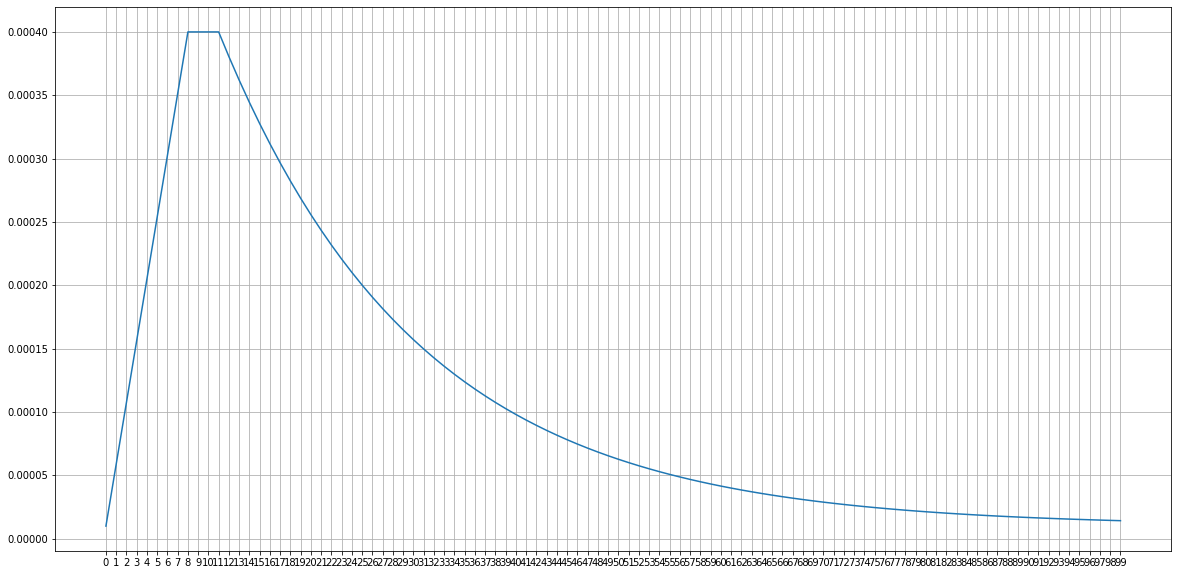

In [26]:
lr0 = mk_lrfn()
lr1 = mk_lrfn(LR_START = 0.00001,LR_MAX = 0.00005,LR_RAMPUP_EPOCHS = 8,LR_SUSTAIN_EPOCHS=3,LR_EXP_DECAY = .95)
lr2 = mk_const_lrfn(0.00001)
plot_lrnfn(lr0)
plot_lrnfn(lr1)

### Compute weight for each class

In [27]:
def get_class_weights(ys):
    """
        ys: numpy array of training etiquettes
        returns weights to be applied for training
    """
    classes=np.unique(ys)
    sk_weights = compute_class_weight('balanced',classes=classes,y=ys)
    return {i:w for (i,w) in zip(classes,sk_weights)}

### Build the model

In [28]:
def mk_model_builder(tkapp,ishape=[*IMAGE_SIZE,3],num_classes=len(CLASSES)):
    def model_builder():
        # fe shall be allocated inside model_builder to benefit from strategy
        fe = tkapp(
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=ishape
        )

        fe.trainable = True
        
        model = tf.keras.Sequential([
            tf.keras.Input(name="input",shape=ishape),
            fe,
            tf.keras.layers.GlobalAveragePooling2D(),     
            tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ])
        return model
        
    return model_builder

def create_dist_model(model_builder,strategy=STRATEGY):
    if strategy is not None:
        with strategy.scope():
            model = model_builder()
            model.compile(
                optimizer=tf.keras.optimizers.Adam(), 
                loss = 'sparse_categorical_crossentropy', 
                metrics = ['sparse_categorical_accuracy']
            )
            return model
    else:
        model = model_builder()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(), 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['sparse_categorical_accuracy']
        )
        return model

### Train the model

In [29]:
def fit_plot(model,train_ds,val_ds,callbacks,weights=None,epochs=EPOCHS,metric="sparse_categorical_accuracy"):
    
    history = model.fit(
        x               = train_ds,
        #steps_per_epoch = STEPS_PER_EPOCH,
        epochs          = epochs,
        callbacks       = callbacks,
        validation_data = val_ds,
        class_weight    = weights
    )
    
    # Loss curve
    plot_train_valid_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)  
     # Accuracy curve
    plot_train_valid_curves(history.history['sparse_categorical_accuracy'],history.history[f'val_{metric}'], 'accuracy', 212)
    
    return model

#### First, train the model on expanded dataset

In [30]:
# useful on GPU ?
#options = tf.data.Options()
#options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
#expanded_ds = expanded_ds.with_options(options)

71688192/71686520 [==============================] - 0s 0us/step
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
70/70 [==============================] - 198s 1s/step - loss: 4.5439 - sparse_categorical_accuracy: 0.0102 - val_loss: 4.6773 - val_sparse_categorical_accuracy: 0.0121


2022-07-26 22:57:54.237832: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 95361, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658876274.237428279","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 95361, Output num: 0","grpc_status":3}


Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
70/70 [==============================] - 44s 429ms/step - loss: 4.3139 - sparse_categorical_accuracy: 0.1141 - val_loss: 4.0156 - val_sparse_categorical_accuracy: 0.2419
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
70/70 [==============================] - 44s 429ms/step - loss: 2.3620 - sparse_categorical_accuracy: 0.5718 - val_loss: 2.4424 - val_sparse_categorical_accuracy: 0.5011
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
70/70 [==============================] - 44s 430ms/step - loss: 0.5526 - sparse_categorical_accuracy: 0.7850 - val_loss: 1.7774 - val_sparse_categorical_accuracy: 0.6075
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
70/70 [==============================] - 45s 436ms/step - loss: 0.2066 - sparse_categorical_accuracy: 0.8952 - val_loss: 1.5026 - val_sparse_categorical_accura

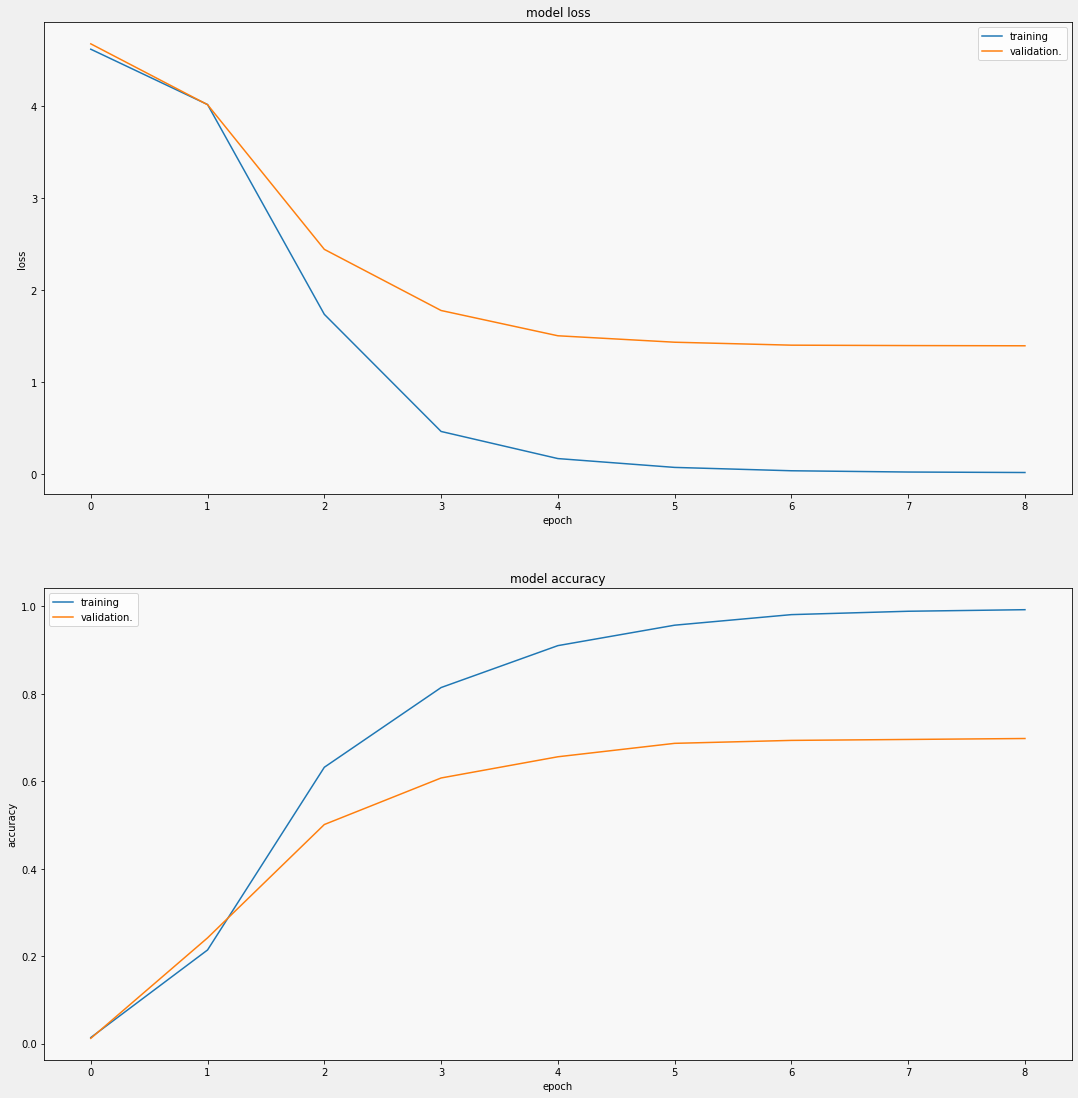

In [31]:
weights = get_class_weights(all_labels(filtered_ds))
model_builder =  mk_model_builder(UT_MODEL)
model = create_dist_model(model_builder)
num_repeat = int(NUM_TRAINING_IMAGES/nb_selected) - 1
num_repeat =  num_repeat if num_repeat > 0 else 1
fitted_model = fit_plot(model,
                     train_ds=apply_data_augment(batch_prefetch(filtered_ds.repeat(num_repeat))).shuffle(2048),
                     #train_ds=shuffle_batch_prefetch(filtered_ds),
                     val_ds=batch_prefetch(val_ds),
                     epochs = 10,
                     callbacks=[mk_lr_callback(lr0),mk_early_stopping_cb(fit_patience=3,fit_min_delta=0.03)],
                     weights=weights)

## Second, train the model on all good quality pictures

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
24/24 [==============================] - 61s 3s/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9510 - val_loss: 1.4157 - val_sparse_categorical_accuracy: 0.6878


2022-07-26 23:05:16.605759: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 148146, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658876716.605626047","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 148146, Output num: 0","grpc_status":3}


Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 5.875e-05.
24/24 [==============================] - 14s 544ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.9534 - val_loss: 1.4300 - val_sparse_categorical_accuracy: 0.6859
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001075.
24/24 [==============================] - 14s 544ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.9550 - val_loss: 1.4083 - val_sparse_categorical_accuracy: 0.6816
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00015625.
24/24 [==============================] - 14s 543ms/step - loss: 0.0853 - sparse_categorical_accuracy: 0.9638 - val_loss: 1.3893 - val_sparse_categorical_accuracy: 0.6837
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


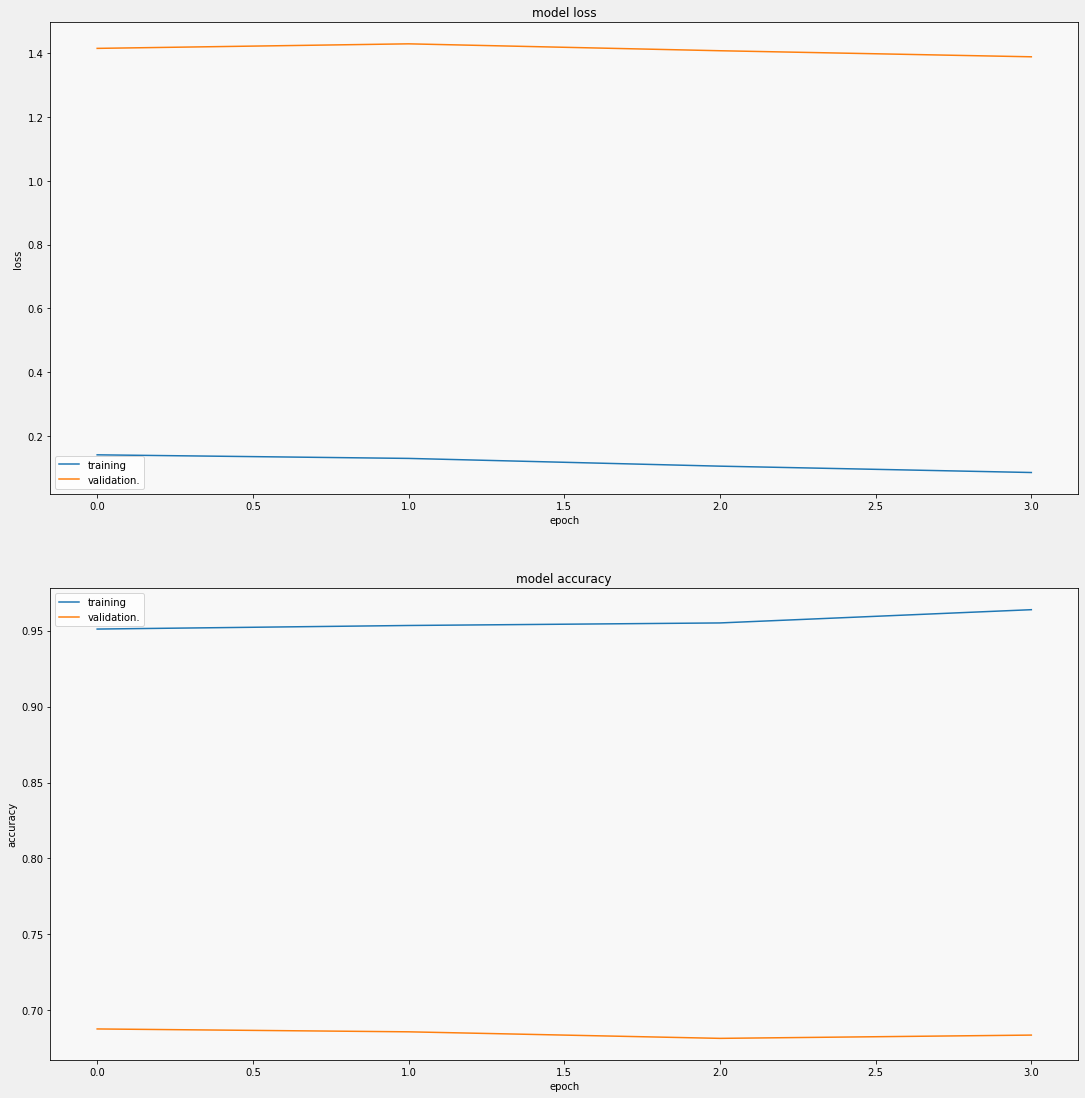

In [32]:
#weights1 = get_class_weights(all_labels(filtered_ds1))
fitted_model = fit_plot(fitted_model,
                     train_ds=shuffle_batch_prefetch(filtered_ds),
                     epochs=15,
                     val_ds=batch_prefetch(val_ds),
                     callbacks=[mk_lr_callback(lr1),mk_early_stopping_cb(fit_patience=3,fit_min_delta=0.01)],
                     weights=weights)

#### Then, only fit dense layer

In [33]:
fitted_model.get_layer(UT_NAME).trainable = False

In [34]:
fitted_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               186472    
Total params: 17,860,295
Trainable params: 186,472
Non-trainable params: 17,673,823
_________________________________________________________________


2022-07-26 23:06:12.652364: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
100/100 [==============================] - 89s 888ms/step - loss: 1.6537 - sparse_categorical_accuracy: 0.6283 - val_loss: 1.1424 - val_sparse_categorical_accuracy: 0.7381


2022-07-26 23:07:44.063417: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 175011, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658876864.063280681","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 175011, Output num: 1","grpc_status":3}


Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-05.
100/100 [==============================] - 42s 416ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.7038 - val_loss: 1.0384 - val_sparse_categorical_accuracy: 0.7640
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 1e-05.
100/100 [==============================] - 42s 416ms/step - loss: 1.0317 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.9662 - val_sparse_categorical_accuracy: 0.7839
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 1e-05.
100/100 [==============================] - 42s 416ms/step - loss: 0.8920 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.8991 - val_sparse_categorical_accuracy: 0.8039
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 1e-05.
100/100 [==============================] - 42s 417ms/step - loss: 0.8048 - sparse_categorical_accuracy: 0.7941 - val_loss: 0.8407 - val_sparse_categorical_accur

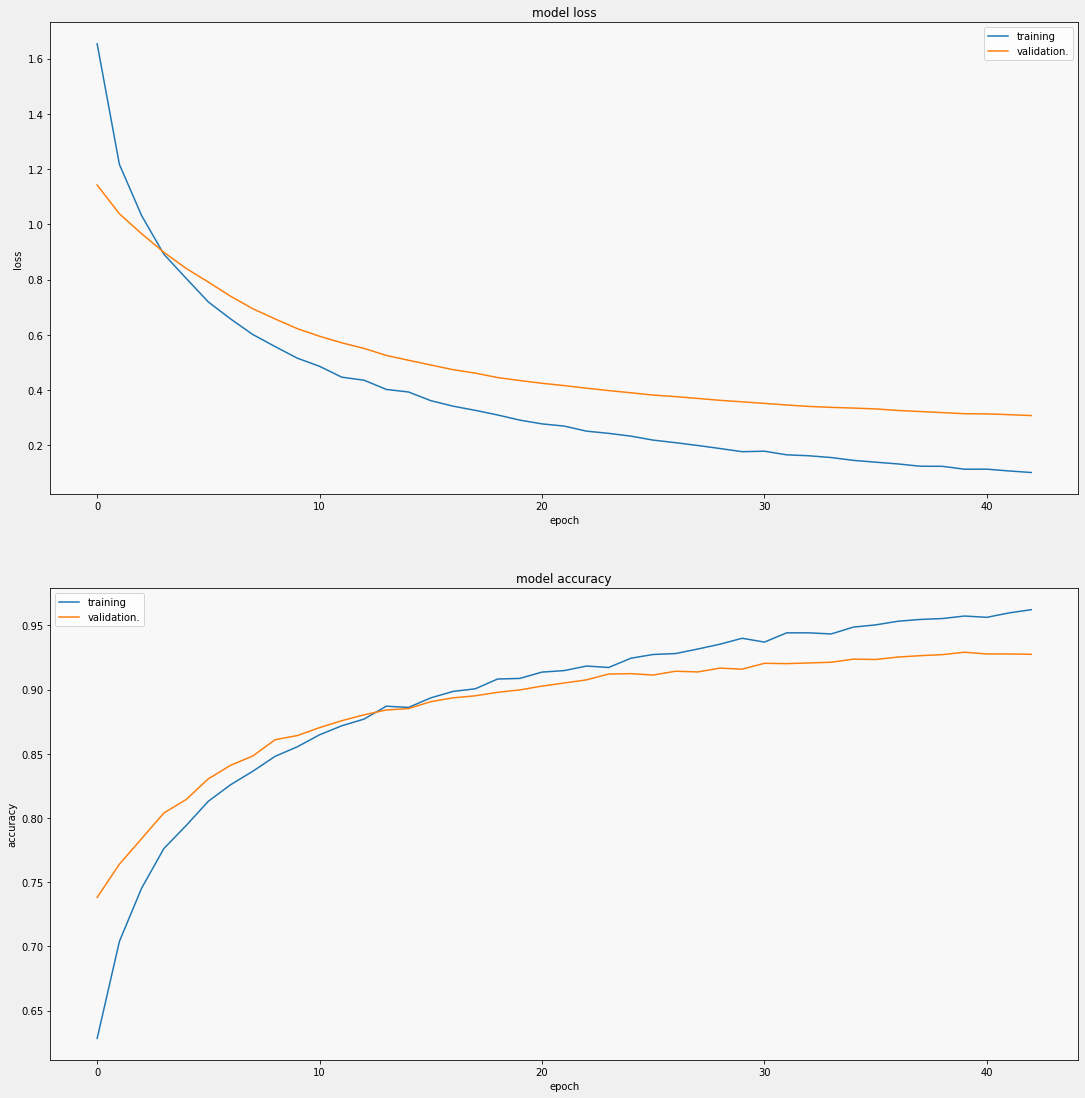

In [35]:
train_ds =  get_training_dataset()
weights = get_class_weights(all_labels(train_ds))
fitted_model = fit_plot(fitted_model,
                     train_ds=shuffle_batch_prefetch(train_ds),
                     val_ds=batch_prefetch(val_ds),
                     callbacks=[mk_lr_callback(lr2),mk_early_stopping_cb(fit_patience=3,fit_min_delta=0.0005)],
                     weights=weights)

### Check model's performance on validation set

In [36]:
cmdataset =  batch_prefetch(get_validation_dataset(ordered=True))

images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch() 

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()  # Get everything as one batch
cm_probabilities = fitted_model.predict(images_ds)  # The probability that each image is of each class
cm_predictions = np.argmax(cm_probabilities.astype(np.float32), axis = -1)  # The class of the largest probability is what we need

print("Correct labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

2022-07-26 23:39:11.500650: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Correct labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


2022-07-26 23:39:28.731327: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 379643, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658878768.731192581","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 379643, Output num: 0","grpc_status":3}


### Draw the confusion matrix, compute F1 score, precision, and recall

In [37]:
#display_n_images_with_predictions(images_ds.unbatch(),cm_predictions,cm_correct_labels,n=9)

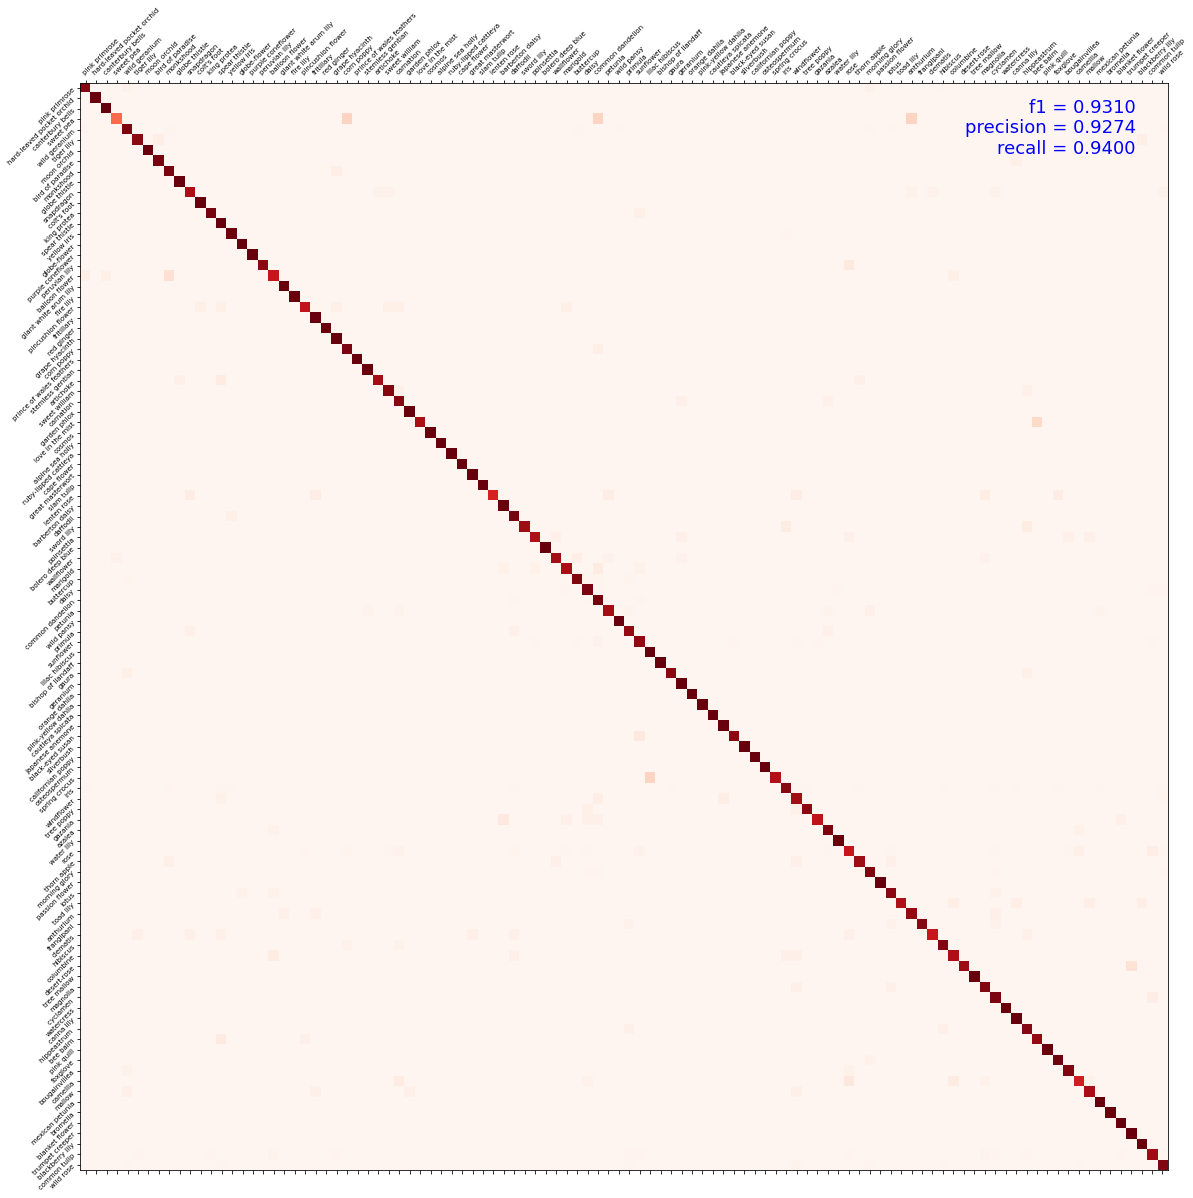

f1 score: 0.931, precision: 0.927, recall: 0.940


In [38]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)), average = 'macro')
cmat = (cmat.T / cmat.sum(axis = 1)).T
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

### Make prediction

In [39]:
def make_prediction(model,test_ds):
    
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities = model.predict(test_images_ds)  # Compute the probability that each image is of each class
    predictions = np.argmax(probabilities.astype(np.float32), axis = -1)  # Use the one with largest probability as the predicted class
    #print(predictions)

    # Generate submission file, remember to name it by "submission.csv"
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    test = pd.DataFrame({"id": test_ids, "label": predictions})
    
    #print(test.head)
    test.to_csv("submission.csv",index = False)
    print("done")
    
make_prediction(fitted_model,batch_prefetch(test_ds))

done
